In [6]:
import pyxdf
import mne
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib qt
mne.viz.set_browser_backend('matplotlib')
from utils import calculate_power_spectrum, plot_power_spectrum

In [7]:
data = pyxdf.load_xdf('shaz_spotify.xdf')
# stream = data[0][0]

Stream 1: Calculated effective sampling rate 290.3914 Hz is different from specified rate 500.0000 Hz.


In [8]:
eeg_stream = next(stream for stream in data[0]
                  if stream['info']['type'][0] == 'EEG')
effective_sampling_rate = eeg_stream['info']['effective_srate']
eeg_channels = [
    ch['label'][0]
    for ch in eeg_stream['info']['desc'][0]['channels'][0]['channel']
    if ch['type'][0] == 'EEG'
]
eeg_data = eeg_stream['time_series']
eeg_data = eeg_data[:, :len(eeg_channels)].T * 1e-6
info = mne.create_info(
    ch_names=eeg_channels, sfreq=effective_sampling_rate, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)
raw = raw.resample(200)

Creating RawArray with float64 data, n_channels=12, n_times=375679
    Range : 0 ... 375678 =      0.000 ...  1293.695 secs
Ready.


In [11]:
flat_voltage = 0.4
flat_voltage *= 1e-6  # Flat voltage threshold in Volts
_, bads = mne.preprocessing.annotate_amplitude(
    raw, flat=dict(eeg=flat_voltage))
raw.info['bads'] = bads
print(f"Bad channels: {bads}")
raw_filt = raw.copy().filter(3, 80, fir_design='firwin')

Finding segments below or above PTP threshold.
Bad channels: []
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 331 samples (1.655 s)



Effective window size : 10.240 (s)
Power shape: (12, 809), Frequency shape: (809,)


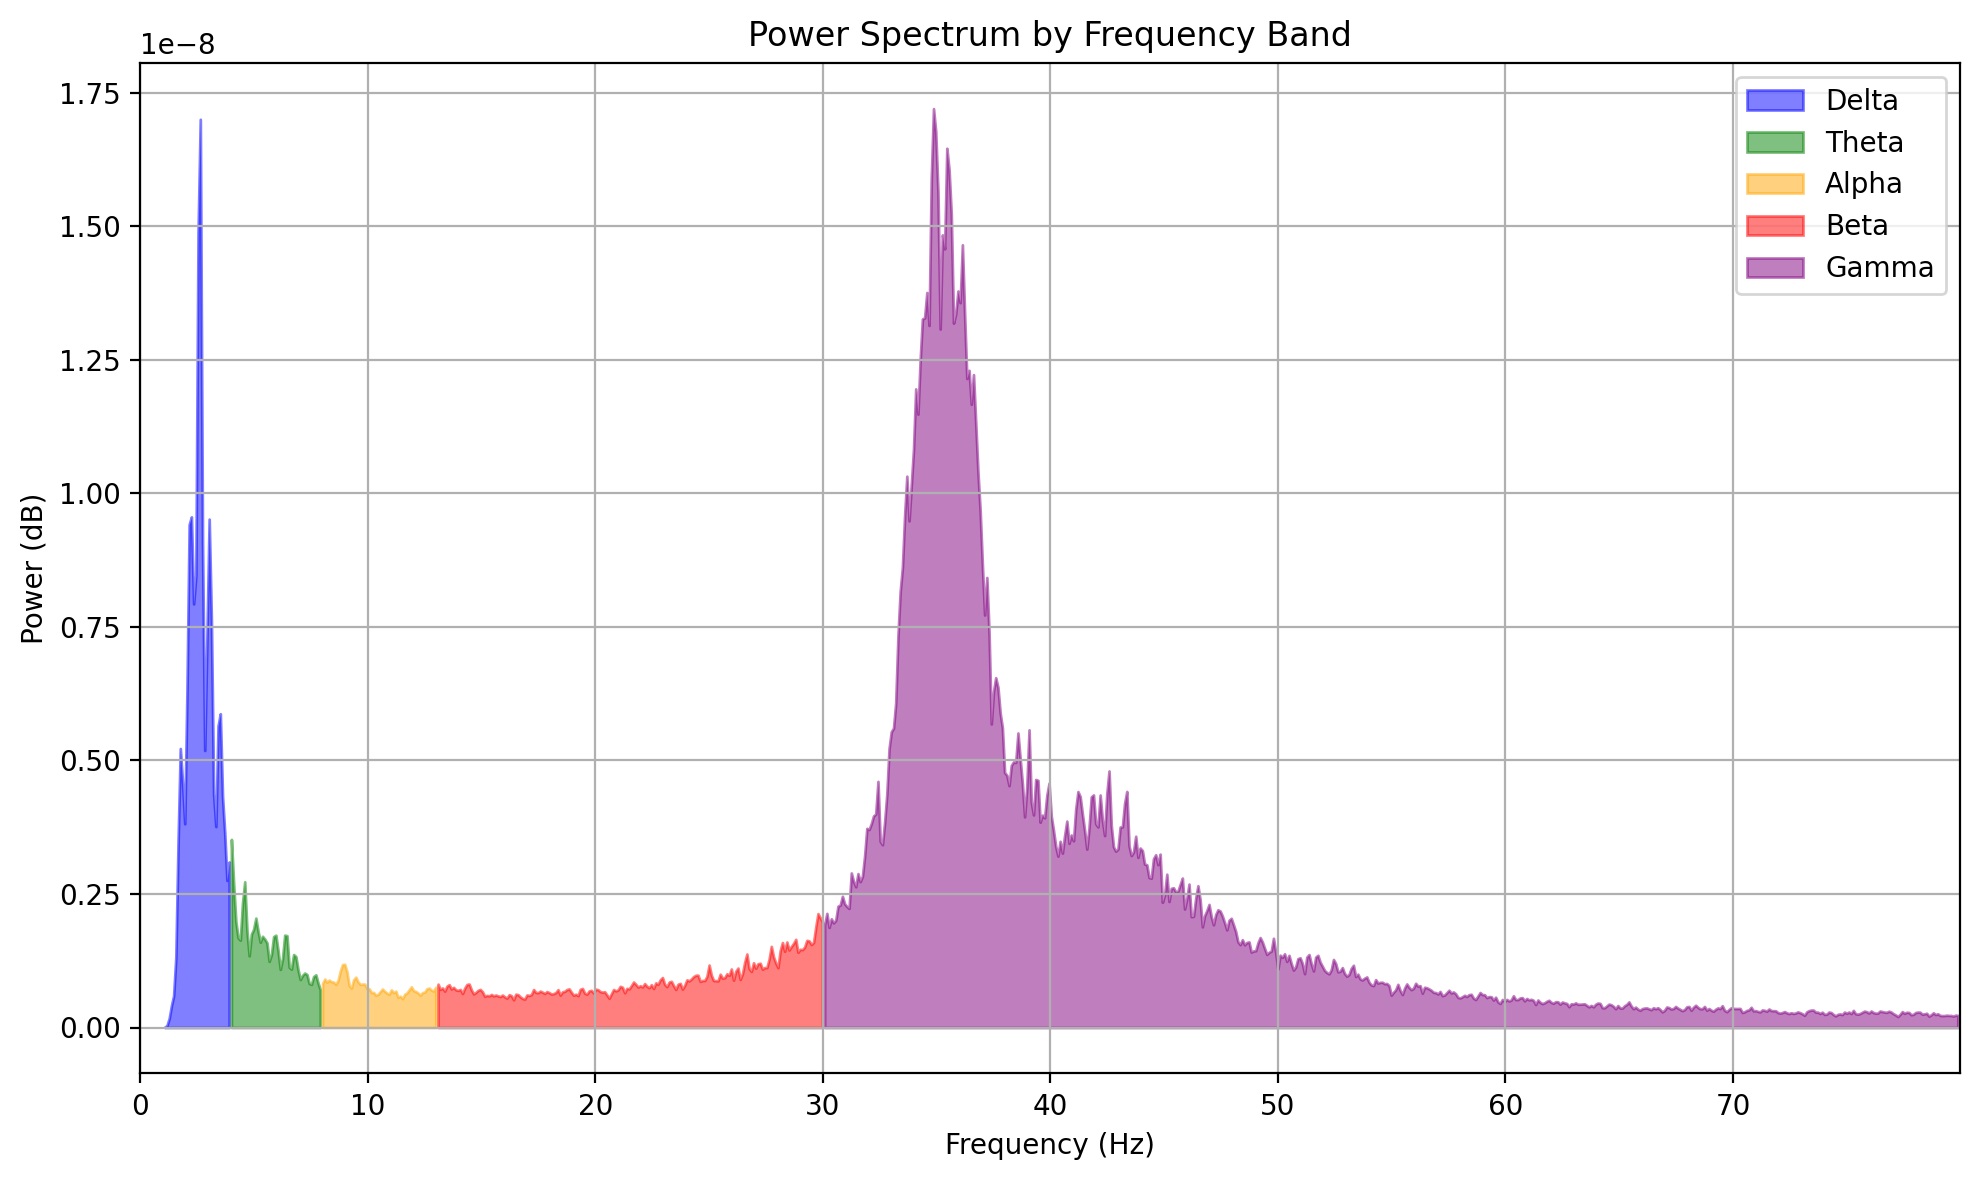

In [12]:
power, freqs = calculate_power_spectrum(raw_filt, fmin=1, fmax=80, method='welch')
plot_power_spectrum(power, freqs, average_axis=0)